#EGU25-7276 | Orals | OS4.4 

# Enhanced Global Sea-Ice CFOSAT sigma₀ maps Reprocessing Utilizing HEALPix-Based Radar within the SROLL Framework  

Gallian, M., Delouis, J.-M., Girard-Ardhuin, F., Belaube, C., and Odaka, T.

Enhanced Global Sea-Ice CFOSAT sigma₀ maps Reprocessing Utilizing HEALPix-Based Radar within the SROLL Framework, EGU General Assembly 2025, Vienna, Austria, 27 Apr–2 May 2025, EGU25-7276, https://doi.org/10.5194/egusphere-egu25-7276, 2025.

In this presentation we investigate sea ice physical parameters by undertaking an extensive reanalysis of radar remote sensing data from SWIM and SCAT sensors onboard the french-chinse CFOSAT satellite. The central objective is to estimate daily maps of sea ice extent, type and displacement from radar sigma_0 data which is linked with surface roughness at a spatial resolution of 12.5 km. For this purpose, it is needed to know biais of the sigma₀ maps, this is what will be presented here. A significant challenge in processing sea-ice data is handling observations concentrated near the poles, where noteworthy features exist, while systematic instrument effects are more stable and manageable at lower latitudes, such as over continents. To prevent biases from arising due to geographic projections, we apply the HEALPix pixelization, functioning as a Discrete Global Grid System (DGGS). This technique enables us to process the complete dataset at once, extracting both instrumental biases and the relevant signal within a cohesive framework. The map production employs SROLL, a methodology originally crafted for processing cosmology data in the Planck mission. SROLL is tailored for calibrating, denoising, and producing consistent maps in a single operation, utilizing all available satellite data. We processed five years of SWIM observations and two years of SCAT data in one run gathering as much as possible all available information. Temporal gaps, related to the scanning strategy, were filled using spline-based interpolation, and detected antenna gain variations were adjusted. Additionally, analyses and compensation were performed for long-term noise fluctuations. The resulting datasets underwent successful validation against independent references, illustrating the approach's robustness. This work underscores SROLL's paradigm efficacy in satellite data processing and emphasizes its potential across space missions beyond cosmology. The data is publicly available in Zarr format, promoting ease of access and compatibility with the xDGGS framework.

# get the data

In this notebook we get the data using Zarr file and an Healpix grid. The following cells show how the plots shown during the EGU meeting has been produced.

In [1]:
#install the proper library
!pip install xdggs
!pip install healpy
!pip install xarray zarr numcodecs

In [2]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xdggs
import zarr
import fsspec
from datetime import datetime, timedelta

fs = fsspec.filesystem("http")
data=xr.open_zarr('https://data-taos.ifremer.fr/EGU25_CFOSAT/CFOSAT_SIGMA0.zarr').pipe(xdggs.decode)
data

<xarray.Dataset> Size: 88GB
Dimensions:   (time: 1160, cells: 3145728)
Coordinates:
  * time      (time) datetime64[ns] 9kB 2019-06-05T12:00:00 ... 2022-08-07T12...
  * cell_ids  (cells) int64 25MB dask.array<chunksize=(196608,), meta=np.ndarray>
Dimensions without coordinates: cells
Data variables:
    SCAT_HH   (time, cells) float64 29GB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    SWIM      (time, cells) float64 29GB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    SCAT_VV   (time, cells) float64 29GB dask.array<chunksize=(1, 196608), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(level=9, indexing_scheme=nested)

In [3]:
time=data.time.compute().data

# use XDGGS to visualise a subregion evolution

In [4]:
# use the GEO convention
grid_info = data.dggs.grid_info
ds = data.dggs.assign_latlon_coords().assign_coords(cell_ids=lambda ds: ("cells", grid_info.geographic2cell_ids(lon=-ds["longitude"].data, lat=ds["latitude"]))).dggs.decode(grid_info).dggs.assign_latlon_coords()

In [5]:
lat = np.arange(-75, -65, 0.1)
lon = np.arange(-35, -5, 0.1)
full_lat = np.repeat(lat, len(lon))
full_lon = np.tile(lon, len(lat))
ds_=ds.SCAT_HH.dggs.sel_latlon(longitude=full_lon, latitude=full_lat).isel(time=10).compute()#.dggs.explore(alpha=0.8)
ds_.dggs.explore(alpha=0.8,cmap='coolwarm')

Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

# compute the sea-ice surface in Antartica

Using the SWIM data that are not strongly affected by the wind, the limit between free water and sea ice is well define.


In [6]:
#compute the index lower than -45 degree in latitude
level=9
p,t=hp.pix2ang(2**level,np.arange(12*4**level),lonlat=True,nest=True)
idx=np.where(t<-45)[0]

#get the masked region
# 5 is the threshold between open water and sea-ice, -1E10 avoid undefined pixels (UNSEEN HEALPIx=-1.6E30)
mask = (data.SWIM[:,idx] < 5)*(data.SWIM[:,idx] >-1E10) # boolean DataArray (same dims as SWIM)
count_per_time = mask.sum(dim='cells')  # sum over 'cells' dimension

# run the query
result = count_per_time.compute()

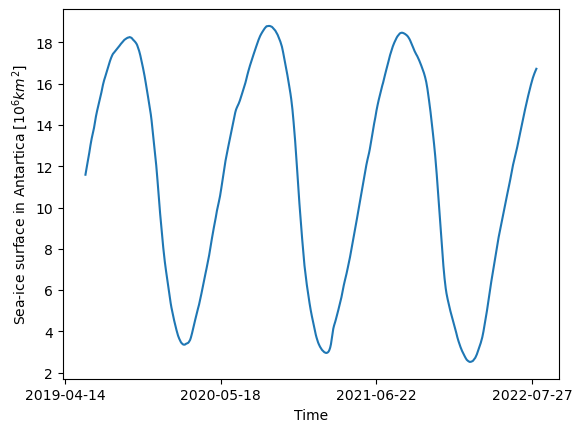

In [7]:
#plot the result

import matplotlib.ticker as ticker
# cell surface is equal to 4\pi/(12*4**level) in radians**2
# then multipling by earth radius square this is converte in km**2
pix_surf=4*np.pi/(12*4**level)*(6378.0)**2

plt.plot(time,result*pix_surf*1E-6)
plt.ylabel('Sea-ice surface in Antartica [$10^6 km^2$]')
plt.xlabel('Time')
# Réduire le nombre de ticks
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(400))

# build a movie of the sea-ice

The next two cells may take some time to run, but they build an RGB movie where each color channel corresponds to one detector channel of CFOSAT.
Note that the data are rescaled to have similar amplitudes.
In the final movie, the color patterns provide information about the sea-ice type, as the HH and VV channels reflect surface roughness, while the low-incidence channel adds complementary information.

/opt/conda/lib/python3.12/site-packages/numpy/ma/core.py:492: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)


([], [])

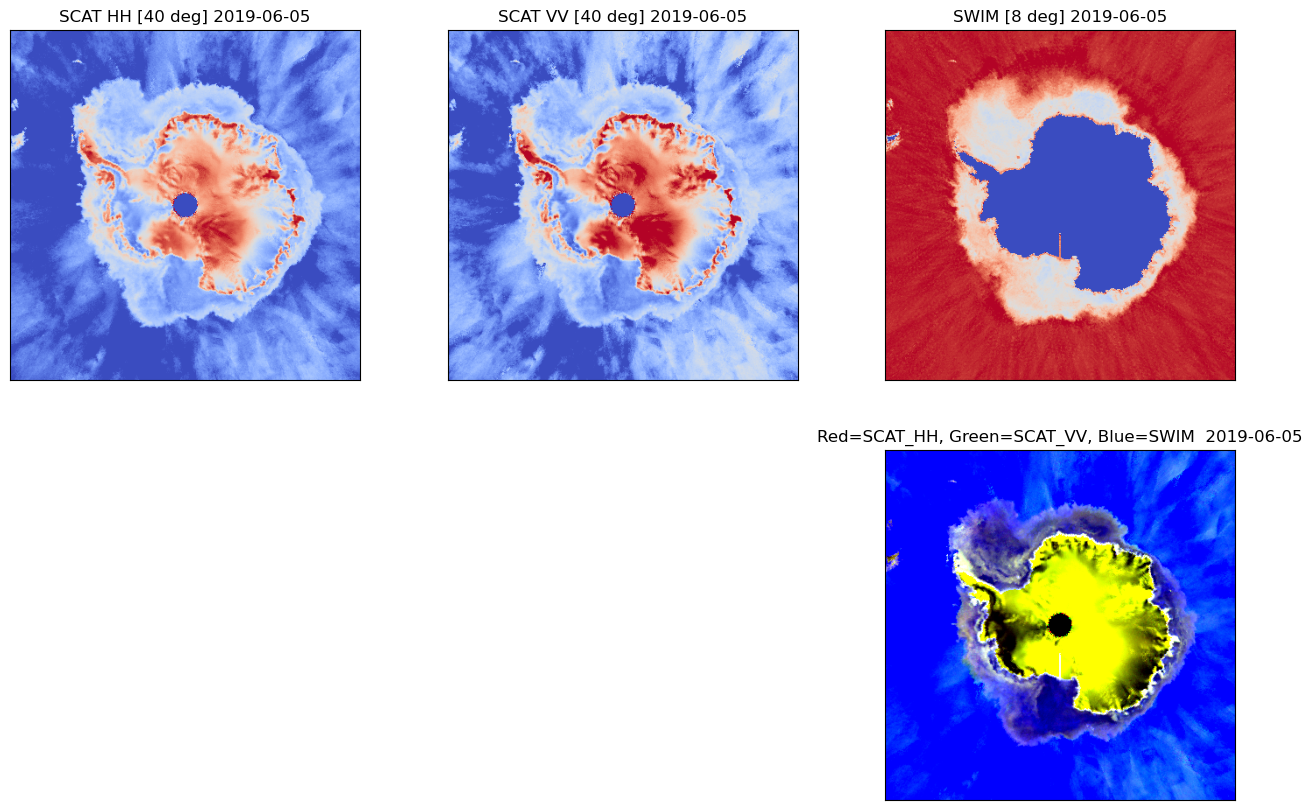

In [8]:
#compute the healpix projection at the north pole for level=9
xsize=400
pidx=hp.gnomview(np.arange(12*(4**9)),reso=12,rot=[0,-90],xsize=xsize,flip='astro',
                 return_projected_map=True,no_plot=True,nest=True).astype('int')
                 
# Setup
imhh=data.SCAT_HH.isel(time=0).compute().data
imvv=data.SCAT_VV.isel(time=0).compute().data
ims=data.SWIM.isel(time=0).compute().data

# select the scale of each chanel to highlight the sea_ice type 
a=-22
b=-5
a1=-20
b1=-5
a2=-15
b2=10

#convert time in a printable format
date_only = time[0].astype('M8[s]').astype(datetime)

# initialise the plot
fig=plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
tl1=plt.title(f'SCAT HH [40 deg] {date_only.date()}')
ln1 = plt.imshow(imhh[pidx],cmap='coolwarm',vmin=a,vmax=b,origin='lower')
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,2)
tl2=plt.title(f'SCAT VV [40 deg] {date_only.date()}')
ln2 = plt.imshow(imvv[pidx],cmap='coolwarm',vmin=a1,vmax=b1,origin='lower')
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,3)
tl3=plt.title(f'SWIM [8 deg] {date_only.date()}')
ln3 = plt.imshow(ims[pidx],cmap='coolwarm',vmin=a2,vmax=b2,origin='lower')
plt.xticks([])
plt.yticks([])
im=np.zeros([xsize,xsize,3])

# apply the scaling to the RGB map
im[:,:,0]=(np.clip(imhh[pidx],a,b)-a)/(b-a)
im[:,:,1]=(np.clip(imvv[pidx],a1,b1)-a1)/(b1-a1)
im[:,:,2]=(np.clip(ims[pidx],a2,b2)-a2)/(b2-a2)
    
plt.subplot(2,3,6)
tl4=plt.title(f'Red=SCAT_HH, Green=SCAT_VV, Blue=SWIM  {date_only.date()}')
ln4 = plt.imshow(np.clip((im-0.2)*2,0.0,1.0),origin='lower')
plt.xticks([])
plt.yticks([])

# Select the ouput path in MYPATH

0  step computed into  30  steps 2019-06-05
1  step computed into  30  steps 2019-06-06
2  step computed into  30  steps 2019-06-07
3  step computed into  30  steps 2019-06-08
4  step computed into  30  steps 2019-06-09
5  step computed into  30  steps 2019-06-10
6  step computed into  30  steps 2019-06-11
7  step computed into  30  steps 2019-06-12
8  step computed into  30  steps 2019-06-13
9  step computed into  30  steps 2019-06-14
10  step computed into  30  steps 2019-06-15
11  step computed into  30  steps 2019-06-16
12  step computed into  30  steps 2019-06-17
13  step computed into  30  steps 2019-06-18
14  step computed into  30  steps 2019-06-19
15  step computed into  30  steps 2019-06-20
16  step computed into  30  steps 2019-06-21
17  step computed into  30  steps 2019-06-22
18  step computed into  30  steps 2019-06-23
19  step computed into  30  steps 2019-06-24
20  step computed into  30  steps 2019-06-25
21  step computed into  30  steps 2019-06-26
22  step computed in

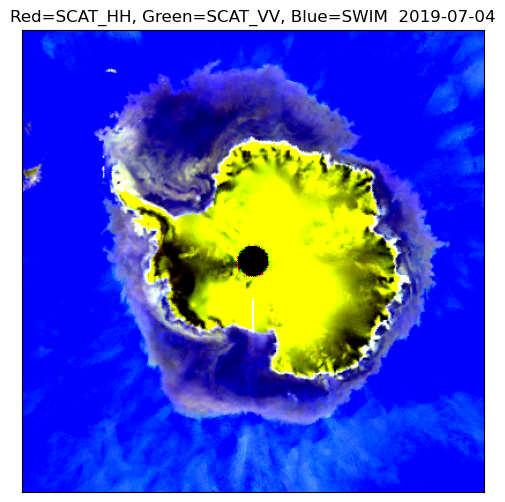

In [9]:
#=====================================================================
MYPATH='.'
#=====================================================================


from matplotlib.animation import FuncAnimation, FFMpegWriter

# Setup
imhh=data.SCAT_HH.isel(time=0).compute().data
imvv=data.SCAT_VV.isel(time=0).compute().data
ims=data.SWIM.isel(time=0).compute().data

# initialise the plot
fig=plt.figure(figsize=(6,6))
im=np.zeros([xsize,xsize,3])

im[:,:,0]=(np.clip(imhh[pidx],a,b)-a)/(b-a)*(ims[pidx]<5)
im[:,:,1]=(np.clip(imvv[pidx],a1,b1)-a1)/(b1-a1)*(ims[pidx]<5)
im[:,:,2]=(np.clip(ims[pidx],a2,b2)-a2)/(b2-a2)
    
date_only = time[0].astype('M8[s]').astype(datetime)
tl1 = plt.title(f'Red=SCAT_HH, Green=SCAT_VV, Blue=SWIM  {date_only.date()}')
ln1 = plt.imshow(np.clip((im-0.2)*2,0.0,1.0),origin='lower')
plt.xticks([])
plt.yticks([])

def init():
    return ln1,tl1

# Fonction d’update
def update(frame):
    date_only = time[frame].astype('M8[s]').astype(datetime)
    imhh=data.SCAT_HH.isel(time=frame).compute().data
    imvv=data.SCAT_VV.isel(time=frame).compute().data
    ims=data.SWIM.isel(time=frame).compute().data
    im[:,:,0]=(np.clip(imhh[pidx],a,b)-a)/(b-a)
    im[:,:,1]=(np.clip(imvv[pidx],a1,b1)-a1)/(b1-a1)
    im[:,:,2]=(np.clip(ims[pidx],a2,b2)-a2)/(b2-a2)
    ln1.set_data(np.clip((im-0.2)*2,0.0,1.0))
    tl1.set_text(f'Red=SCAT_HH, Green=SCAT_VV, Blue=SWIM  {date_only.date()}')
    if frame%1==0:
        print(frame,' step computed into ',ntest,' steps',  date_only.date())
    return ln1, tl1

# run the animation
# ntest=len(time) Could be long
ntest=30

ani = FuncAnimation(fig, update, frames=np.arange(ntest),
                    init_func=init, blit=True)

# Define an MP4 writer
writer = FFMpegWriter(fps=15, bitrate=1800)

# Save the animation
ani.save(MYPATH+'/EGU_ANIM.mp4', writer=writer)

print('Done')